# <center>PrivacyBench: Federated Learning (ViT)</center>

## Evaluating Federated Learning with ViT

As part of the PrivacyBench benchmarking suite, this notebook implements Federated Learning (FL) using a Vision Transformer (ViT) to evaluate how privacy-preserving decentralization impacts transformer-based model utility, training efficiency, and energy consumption.

--- 

In [1]:
%load_ext autoreload
%load_ext watermark
    
%autoreload 2
%watermark --python -p torch,flwr

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.1.0

torch: 2.6.0
flwr : 1.18.0



--------

## Loading Dependencies

In [2]:
import os
import sys
sys.path.append("../..")

import ray
import time

import torch.nn as nn
from transformers import ViTForImageClassification

from logging import ERROR

from flwr.common import ndarrays_to_parameters, Context 
from flwr.client import Client, ClientApp
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg 
from flwr.simulation import run_simulation 

from src.config import ExperimentName
from src.FL_client import MedicalImageClient
from src.FL_server import weighted_average, build_evaluate_fn
from src.paths import RAY_LOG_DIR
from src.local_utility import load_yaml_config, get_weights, set_device, prepare_FL_dataset
from src.tracker import reset_base_memory_csv

------

In [3]:
# Replace with appropritate values
data_name_ = "skin_lesions" #'alzheimer' #
base_type_ = "vit"       
exp_name_ = "FL"
num_labels_ = 8 #Alzheimer-4 & skin_lesions-8 classlabels
experiment_name_ = ExperimentName.FL_VIT 

In [4]:
DEVICE = set_device()
reset_base_memory_csv()

fed_config = load_yaml_config(key="experiments", item_name=experiment_name_)
client_dataloaders = prepare_FL_dataset(exp_name = exp_name_, data_name=data_name_, base_type=base_type_, augment_data=True)

------

In [5]:
def client_fn(context: Context) -> Client:
    """
    Creates and initializes a federated learning client.

    This function initializes a client in the federated learning setup by 
    assigning a unique partitioned dataset and a machine learning model 
    for training and validation.

    Args:
        context (Context): The execution context containing client-specific configurations.

    Returns:
        Client: A configured federated learning client ready to participate in training.
    """
    partition_id = int(context.node_config["partition-id"]) #<--- Get the client partition ID
    
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", 
                                                      num_labels=num_labels_, 
                                                      ignore_mismatched_sizes=True
                                                      )

    # Assign partitioned client dataset
    train_loader, val_loader, test_loader = client_dataloaders[partition_id]
    
    return MedicalImageClient(model, train_loader, val_loader, exp_name=exp_name_, data_name=data_name_, base_type=base_type_, client_id=partition_id).to_client()

client = ClientApp(client_fn)

In [6]:
def server_fn(context: Context):
    """
    Creates and configures the federated learning server using the FedAvg strategy.

    This function initializes the federated learning server with a FedAvg strategy,
    specifying the parameters for client participation in training and evaluation,
    the global model evaluation function, and the metric aggregation function.

    Args:
        context (Context): The execution context for the federated learning server.

    Returns:
        ServerAppComponents: A configured server application with the defined strategy
        and server settings.
    """
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=num_labels_)
    params = ndarrays_to_parameters(get_weights(model))

    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,                 #<--- Sample 100% of available clients for training
        fraction_evaluate=1.0,            #<--- Sample 100% of available clients for evaluation
        initial_parameters=params,        #<--- Initial model parameters
        evaluate_fn=build_evaluate_fn(    #<--- Global evaluation function
            exp_name = exp_name_, 
            base_type = base_type_,
            data_name=data_name_, 
            experiment_item=experiment_name_, 
            num_labels=num_labels_
            ), 
        evaluate_metrics_aggregation_fn=weighted_average,  #<-- pass the metric aggregation function
    )

    # Configure the server with the specified number of federated rounds
    sever_config = ServerConfig(num_rounds=fed_config['num_rounds']) #<--- no. of federated rounds
    
    return ServerAppComponents(strategy = strategy, config = sever_config)


# Wrap the server function in a ServerApp, and instantiate it
server = ServerApp(server_fn = server_fn) 

----- 

Set up our backend configurations before running the simulation

> - `init_args`: filter logging coming from the Simulation Engine so it's more readable in notebooks
> - `client_resources`: by default, allocate to each client 1x CPU and 0x GPUs. However, when running on GPU, assign an entire GPU for each client

In [7]:
backend_setup = {
    "init_args": {
        "logging_level": ERROR, 
        "log_to_driver": fed_config.get("log_to_driver")
    },
    "client_resources": {
        "num_cpus": fed_config.get("num_cpus"), 
        "num_gpus": fed_config.get("num_gpus")            
    },
}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda": 
    backend_setup["client_resources"] = {"num_cpus": 1, "num_gpus": 1.0}

--- 

## Initiate the Simulation 

Initiate the simulation by passing the server and client apps, and specify the number of supernodes that will be selected on every round. 

2025-05-14 14:45:41,131	INFO worker.py:1771 -- Started a local Ray instance.
2025-05-14 14:45:41,635	INFO packaging.py:530 -- Creating a file package for local directory '/home/emeka/PrivacyBench'.
2025-05-14 14:45:42,315	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_ed9f9355efc932e1.zip' (24.80MiB) to Ray cluster...
2025-05-14 14:45:42,391	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_ed9f9355efc932e1.zip'.
05/14/2025 14:45:43:DEBUG:Asyncio event loop already running.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
IN

(ClientAppActor pid=126283) 
(ClientAppActor pid=126283) 🔎 Tracker: FL (ViT)
(ClientAppActor pid=126283) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_ViT/client_emissions.csv
(ClientAppActor pid=126283) ⏱️ Total training time: 8 minutes 46 seconds


(ClientAppActor pid=126283) /home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
(ClientAppActor pid=126283)   df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])
(ClientAppActor pid=126283) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=126283) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=126283) Seed set to 42
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.

(ClientAppActor pid=126282) 
(ClientAppActor pid=126282) 🔎 Tracker: FL (ViT)
(ClientAppActor pid=126282) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_ViT/client_emissions.csv
(ClientAppActor pid=126282) ⏱️ Total training time: 9 minutes 15 seconds


(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpyt

(ClientAppActor pid=126283) 
(ClientAppActor pid=126283) 🔎 Tracker: FL (ViT)
(ClientAppActor pid=126283) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_ViT/client_emissions.csv
(ClientAppActor pid=126283) ⏱️ Total training time: 8 minutes 51 seconds


INFO :      aggregate_fit: received 3 results and 0 failures
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=124021) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (1, 0.6292397684883326, {'accuracy': 0.8027956989247312}, 1125.4803097889999)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=126282) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'cla

(ClientAppActor pid=126283) 
(ClientAppActor pid=126283) 🔎 Tracker: FL (ViT)
(ClientAppActor pid=126283) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_ViT/client_emissions.csv
(ClientAppActor pid=126283) ⏱️ Total training time: 8 minutes 51 seconds


(ClientAppActor pid=126283) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=126283) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=126283) Seed set to 42
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()


(ClientAppActor pid=126282) 
(ClientAppActor pid=126282) 🔎 Tracker: FL (ViT)
(ClientAppActor pid=126282) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_ViT/client_emissions.csv
(ClientAppActor pid=126282) ⏱️ Total training time: 9 minutes 15 seconds


(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpyt

(ClientAppActor pid=126283) 
(ClientAppActor pid=126283) 🔎 Tracker: FL (ViT)
(ClientAppActor pid=126283) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_ViT/client_emissions.csv
(ClientAppActor pid=126283) ⏱️ Total training time: 8 minutes 51 seconds


INFO :      aggregate_fit: received 3 results and 0 failures
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=124021) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (2, 0.5811095370732452, {'accuracy': 0.8440860215053764}, 2259.955491110999)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=126282) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'clas

(ClientAppActor pid=126283) 
(ClientAppActor pid=126283) 🔎 Tracker: FL (ViT)
(ClientAppActor pid=126283) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_ViT/client_emissions.csv
(ClientAppActor pid=126283) ⏱️ Total training time: 8 minutes 51 seconds


(ClientAppActor pid=126283) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=126283) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=126283) Seed set to 42
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()


(ClientAppActor pid=126282) 
(ClientAppActor pid=126282) 🔎 Tracker: FL (ViT)
(ClientAppActor pid=126282) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_ViT/client_emissions.csv
(ClientAppActor pid=126282) ⏱️ Total training time: 9 minutes 13 seconds


(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpyt

(ClientAppActor pid=126283) 
(ClientAppActor pid=126283) 🔎 Tracker: FL (ViT)
(ClientAppActor pid=126283) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_ViT/client_emissions.csv
(ClientAppActor pid=126283) ⏱️ Total training time: 8 minutes 51 seconds


INFO :      aggregate_fit: received 3 results and 0 failures
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=124021) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (3, 0.5638351049597139, {'accuracy': 0.8604301075268818}, 3393.4347768869993)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=126282) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'cla

(ClientAppActor pid=126283) 
(ClientAppActor pid=126283) 🔎 Tracker: FL (ViT)
(ClientAppActor pid=126283) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_ViT/client_emissions.csv
(ClientAppActor pid=126283) ⏱️ Total training time: 8 minutes 51 seconds


(ClientAppActor pid=126283) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=126283) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=126283) Seed set to 42
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()


(ClientAppActor pid=126282) 
(ClientAppActor pid=126282) 🔎 Tracker: FL (ViT)
(ClientAppActor pid=126282) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_ViT/client_emissions.csv
(ClientAppActor pid=126282) ⏱️ Total training time: 9 minutes 12 seconds


(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpyt

(ClientAppActor pid=126283) 
(ClientAppActor pid=126283) 🔎 Tracker: FL (ViT)
(ClientAppActor pid=126283) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_ViT/client_emissions.csv
(ClientAppActor pid=126283) ⏱️ Total training time: 8 minutes 50 seconds


INFO :      aggregate_fit: received 3 results and 0 failures
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=124021) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (4, 0.5644124354090707, {'accuracy': 0.8651612903225806}, 4526.881250081)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=126282) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classif

(ClientAppActor pid=126283) 
(ClientAppActor pid=126283) 🔎 Tracker: FL (ViT)
(ClientAppActor pid=126283) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_ViT/client_emissions.csv
(ClientAppActor pid=126283) ⏱️ Total training time: 8 minutes 51 seconds


(ClientAppActor pid=126283) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=126283) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=126283) Seed set to 42
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()


(ClientAppActor pid=126282) 
(ClientAppActor pid=126282) 🔎 Tracker: FL (ViT)
(ClientAppActor pid=126282) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_ViT/client_emissions.csv
(ClientAppActor pid=126282) ⏱️ Total training time: 9 minutes 12 seconds


(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=126283) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=126283)   self.pid = os.fork()
(ClientAppActor pid=126283) /home/emeka/.local/share/uv/python/cpyt

(ClientAppActor pid=126283) 
(ClientAppActor pid=126283) 🔎 Tracker: FL (ViT)
(ClientAppActor pid=126283) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_ViT/client_emissions.csv
(ClientAppActor pid=126283) ⏱️ Total training time: 8 minutes 50 seconds


INFO :      aggregate_fit: received 3 results and 0 failures
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=124021) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/emeka/.netrc
wandb: Currently logged in as: emyrs to https://api.wandb.ai. Use `wandb login --re

/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=124021) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()



 ___________________________________________________________________________________________________
ExperimentName.FL_VIT Model Final Evaluation 

Test Accuracy: 87.31% | Precision: 0.87 | Recall: 0.87 | F1-Score: 0.87 | ROC-AUC: 0.98 | MCC: 0.82
 


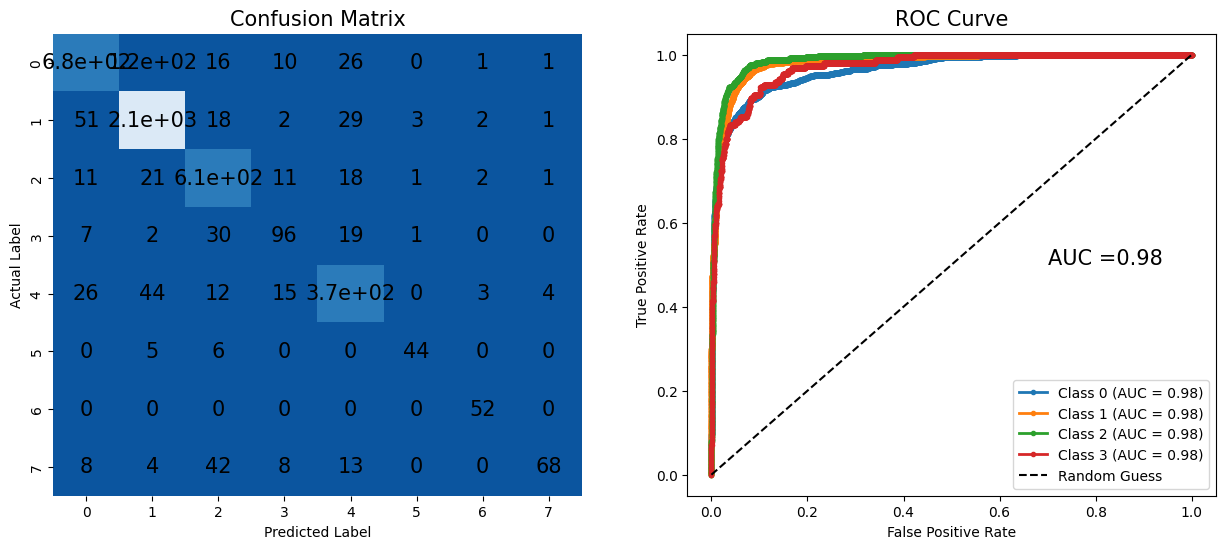


 ___________________________________________________________________________________________________
ExperimentName.FL_VIT--skin_lesions Model Classification Report
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       853
           1       0.92      0.95      0.93      2242
           2       0.83      0.90      0.87       674
           3       0.68      0.62      0.65       155
           4       0.78      0.78      0.78       476
           5       0.90      0.80      0.85        55
           6       0.87      1.00      0.93        52
           7       0.91      0.48      0.62       143

    accuracy                           0.87      4650
   macro avg       0.84      0.79      0.81      4650
weighted avg       0.87      0.87      0.87      4650

___________________________________________________________________________________________________

📊 Consolidated Metrics:
⏱️ Total Duration: 8325.04 sec
✅ Total Energy: 0.36175 kWh

Accuracy,▁
F1-Score,▁
MCC,▁
Peak FL CPU RAM (GB),▁
Peak FL GPU VRAM (GB),▁
Precision,▁
ROC-AUC,▁
Recall,▁
Total FL CO2 Emitted (kg),▁
Total FL Duration (sec),▁
Total FL Energy (kWh),▁


/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])
INFO :      fit progress: (5, 0.5616748299663377, {'accuracy': 0.8731182795698925}, 5715.654092818)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=126282) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=126282) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(Clie


🕒 Total Time: 96 min 25 sec


In [8]:
project_root =  os.path.abspath("../..")

ray.shutdown()

ray.init(
    _temp_dir=str(RAY_LOG_DIR),
    runtime_env={"working_dir": project_root, 'excludes': ['data', '.cache', '.docker', '.local', 'logs/model']}
    )

start_time = time.perf_counter()

run_simulation(
    server_app = server,
    client_app = client,
    num_supernodes = fed_config.get("num_clients"),
    backend_config=backend_setup
)

end_time = time.perf_counter()
duration = end_time - start_time
print(f"\n🕒 Total Time: {duration // 60:.0f} min {duration % 60:.0f} sec")

ray.shutdown()

-----